## Star classification dataset

The purpose of this notebook is to use photometric and spectroscopy data observations to classify three types of objects: stars, galaxies, and quasars.

The dataset is provided by the [SDSS project (Sloan Digital Sky Survey)](https://en.wikipedia.org/wiki/Sloan_Digital_Sky_Survey). The data contains thousands of photometric observations of astronomical objects. Each observation is labeled with the type of objects which can be galaxies, stars, and quasars.

What type of data are we dealing with? 

The SDD telescopes are equipped with imaging cameras that measure the intensity of incoming radiation in the electromagnetic spectrum. In the cameras, different type of filters are placed to measure the radiation at different frequencies. This intensities are available as features in the dataset:

-  **u**: ultraviolet light
-  **g**: blue and green visible light
-  **r**: yellow and red visible light
-  **i**: near-infrared light
-  **z**: near-infrared light

In addition to the above filters, the dataset includes a measurement of the redshift (**z**). For a celestial body, this value is defined as the difference between observed and emitted wavelength, divided by the emitted wavelength. [Read this](https://voyages.sdss.org/preflight/light/redshift/) for a more extended explanation.

Furthremore, we also have the data for the coordinates of the celestial objects. These are the **alpha** and **delta** and represent the coordinates on the celestial sphere. This [post](https://voyages.sdss.org/preflight/locating-objects/ra-dec/) describes how they are measured. For the purpose of this analysis it is useful to understand that they represent coordinates in degrees.

All the previously described data measurements are used to create a model for star classification.

This notebook is organzied as follows:

- [Data importing](#data-import)
- [Explroatory data analysis](#exploratory-data-analysis)
    - [Feature distribution](#feature-distribution)
    - [Feature importance](#feature-importance)
- Data cleaning
- Feature engineering
- Model training

# TODOS:

- Complete feature importance (~1,5h) [x]
- Check xboost feature importance (~1,5h) [x]
- Convert training to exectuable script (~1h) [x]
- Check how to deploy the model (~4h??)
- Containerization (~3h??)
- Deployment to cloud (~5h?)
- Improve readme and documentation (3h)

Total hours: ~15

## Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data import

In [3]:
df = pd.read_csv("data/star_classification.csv")
print("Data length: ", len(df))
df.head()

Data length:  100000


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


Some of the columns above are metadata and are not important for classification purposes. Let's select the relevant features:

In [4]:
position_columns = ["alpha", "delta"]
filter_columns = ["u", "g", "r", "i", "z","redshift"]
target_col = ["class"]

df = df[position_columns + filter_columns + target_col]

## Exploratory data analysis

In [5]:
df.describe()

,alpha,delta,u,g,r,i,z,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,0.576661
std,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,0.730707
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,-0.009971
25%,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,0.054517
50%,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,0.424173
75%,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,0.704154
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   redshift  100000 non-null  float64
 8   class     100000 non-null  object 
dtypes: float64(8), object(1)
memory usage: 6.9+ MB


### Features distribution


In order to perform the feature analysis, it is useful to split the features into two different sets: positional features and filter features.

In [7]:
df[filter_columns].describe()

,u,g,r,i,z,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,21.980468,20.531387,19.645762,19.084854,18.668810,0.576661
std,31.769291,31.750292,1.854760,1.757895,31.728152,0.730707
min,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,-0.009971
25%,20.352353,18.965230,18.135828,17.732285,17.460677,0.054517
50%,22.179135,21.099835,20.125290,19.405145,19.004595,0.424173
75%,23.687440,22.123767,21.044785,20.396495,19.921120,0.704154
max,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


By checking the mean values and some quantils, it is clear that the -9999 values are outliers and should be removed from the data.

In [8]:
df = df[(df["u"] != -9999.0) & (df["g"] != -9999.0) & (df["z"] != -9999.0)]

Now I can observe the distributions of all relevant values and their relationship

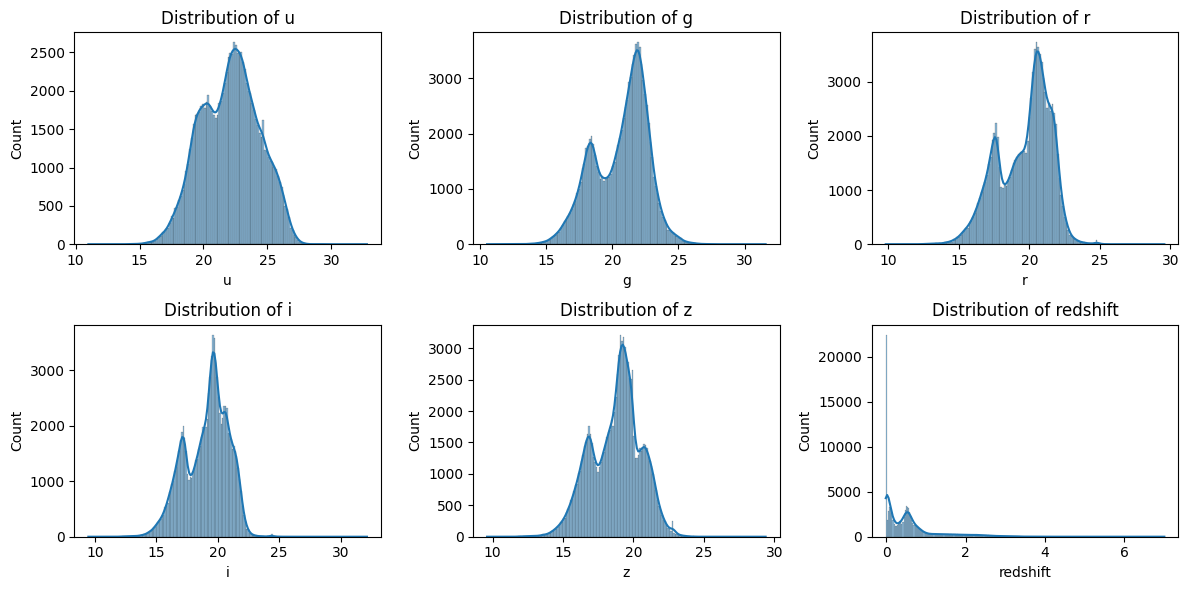

In [9]:
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Flatten the axes array
axes = axes.flatten()

# Loop through each column and plot its distribution
for i, col in enumerate(filter_columns):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Most of the distributions above appear to be bimodal which is a mixture of two normal distributions. However, even simple models such as logistic regression can deal with these type of features. 

Next, I want to observe the distribution of the positional features.

In [10]:
df[position_columns].describe()

,alpha,delta
count,99999.000000,99999.000000
mean,177.628653,24.135552
std,96.502612,19.644608
min,0.005528,-18.785328
25%,127.517698,5.147477
50%,180.900527,23.646462
75%,233.895005,39.901582
max,359.999810,83.000519


<Figure size 1500x500 with 0 Axes>

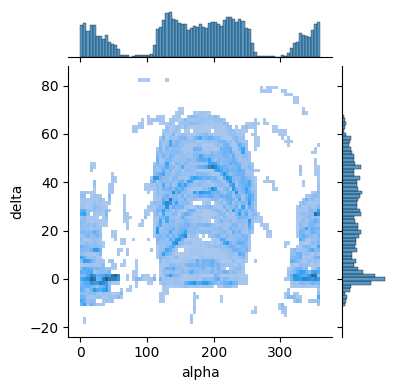

In [11]:
# Set up the matplotlib figure
# sns.set(rc={'figure.figsize':(2,2)})
plt.figure(figsize=(15,5))
sns.jointplot(data=df, x="alpha", y="delta", kind="hist", height=4)
plt.show()

From the distribution above it can be understood that the values of these coordinates cover more and less an entire sphere. alpha (~0-360), delta (~0-90).

### Feature importance

What classes are available and how are they balanced?

In [12]:
df["class"].value_counts()

class
GALAXY    59445
STAR      21593
QSO       18961
Name: count, dtype: int64

Next, check the feature statistics for each class

In [13]:
df[df["class"] == "GALAXY"][filter_columns].describe()

,u,g,r,i,z,redshift
count,59445.000000,59445.000000,59445.000000,59445.000000,59445.000000,59445.000000
mean,22.587379,20.906101,19.587552,18.851990,18.449156,0.421596
std,2.264355,2.107755,1.874133,1.689809,1.656302,0.264858
min,13.897990,12.679020,11.746640,11.299560,10.897380,-0.009971
25%,20.794760,18.912680,17.817150,17.379670,17.095670,0.164527
50%,22.841770,21.582200,20.104590,19.223660,18.766630,0.456274
75%,24.207410,22.445130,20.974610,19.947090,19.472260,0.594699
max,29.325650,31.602240,29.571860,30.163590,29.383740,1.995524


In [14]:
df[df["class"] == "STAR"][filter_columns].describe()

,u,g,r,i,z,redshift
count,21593.000000,21593.000000,21593.000000,21593.000000,21593.000000,21593.000000
mean,21.153830,19.617142,18.947005,18.543760,18.334295,-0.000115
std,2.360482,2.119478,1.972825,1.841753,1.843201,0.000465
min,12.101680,10.498200,9.822070,9.469903,9.612333,-0.004136
25%,19.327740,18.034870,17.453950,17.139600,16.964170,-0.000295
50%,21.010650,19.542830,18.955130,18.592390,18.319230,-0.000076
75%,22.960630,21.228770,20.557570,20.041980,19.729630,0.000075
max,30.660390,30.607000,29.374110,30.250090,26.427790,0.004153


In [15]:
df[df["class"] == "QSO"][filter_columns].describe()

,u,g,r,i,z,redshift
count,18961.000000,18961.000000,18961.000000,18961.000000,18961.000000,18961.000000
mean,21.547619,20.926193,20.624089,20.431173,20.266732,1.719676
std,1.495879,1.163239,1.084237,1.080135,1.095076,0.913954
min,10.996230,13.662170,12.357630,12.637440,11.302470,0.000461
25%,20.637640,20.249730,20.006330,19.811070,19.644250,1.106605
50%,21.503240,21.056290,20.772720,20.582110,20.373970,1.617232
75%,22.286470,21.687770,21.413450,21.202280,21.001230,2.220279
max,32.781390,27.894820,27.397090,32.141470,28.790550,7.011245


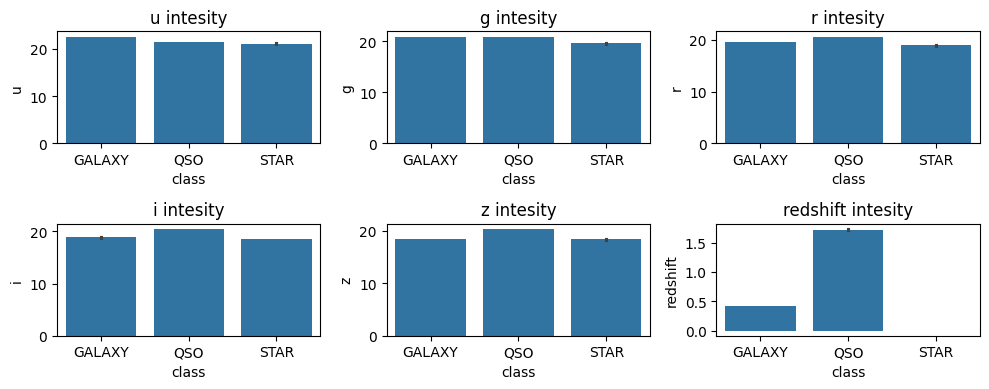

In [16]:
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 3, figsize=(10, 4))

# Flatten the axes array
axes = axes.flatten()

# Loop through each column and plot the bar chart
for i, col in enumerate(filter_columns):
    sns.barplot(x="class", y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} intesity')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

From the different statistics and plots above, it can be infered that the readshift plays an important role in the prediction of the type of celestial object. For the type **QSO** (quasar), we observe a redshift of 1.71 whereas for **STAR** we get only values close to zero and for **GALAXY** we get 0.42 in average.

This result is not surpriging as galaxies are much further away than stars. As the redshift is a result of the Doppler effect, which occurs when an object is moving away from an observer. In the case of galaxies, their redshift indicates that they are receding from us, suggesting that they are indeed distant galaxies.

As for the other feaures, there are not important observable differences between classes. When training the model, we will be able to check what predictive power each feature has. 

## Modeling

### Data preparation

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# check how the classes are balanced

df["class"].value_counts()

class
GALAXY    59445
STAR      21593
QSO       18961
Name: count, dtype: int64

In [19]:
map_class = {
    "GALAXY": 0,
    "STAR": 1,
    "QSO": 2
}

df["target"] = df["class"].apply(lambda x: map_class[x])
X = df[filter_columns]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic regression 

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [21]:
def plot_confusion_matrix(conf_matrix):
    # Create a heatmap
    class_names = ["GALAXY", "STAR", "QSO"]

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     11904
           1       0.94      1.00      0.97      4286
           2       0.94      0.87      0.90      3810

    accuracy                           0.95     20000
   macro avg       0.95      0.94      0.94     20000
weighted avg       0.95      0.95      0.95     20000



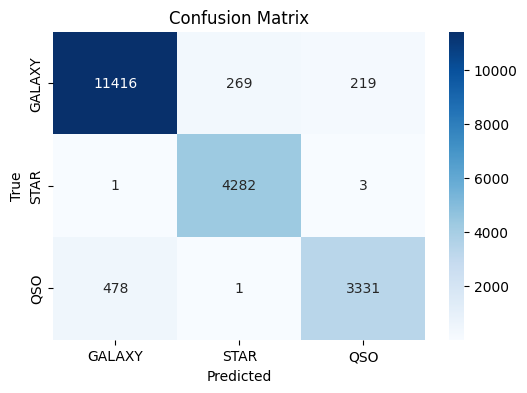

In [22]:
# Initialize the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty="l2", max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute precision, recall, f1-score, support (for each class)
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)
plot_confusion_matrix(conf_matrix)

### XGBoost

Although the linear model exhibits a really good performance, an xgboost might perform better has it can deal with non linearities.

In [23]:
import xgboost as xgb
import numpy as np
from scipy.stats import uniform, randint

Find the best combination of training parameters with a grid search:

In [24]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.05, 0.2), # default 0.1 
    "max_depth": randint(7, 10), # default 3
    "n_estimators": randint(100, 140), # default 100
    "subsample": uniform(0.6, 0.4)
}

# Unlike logistic regression, use positional columns.
X = df[position_columns + filter_columns]
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The optimization consumes a lot of computational resources
# Run only once to find out optimal parameters
RUN_OPTIMIZATION = False

if RUN_OPTIMIZATION:
    search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)
    search.fit(X_train, y_train)
    report_best_scores(search.cv_results_, 3)

Fit a model with the parameters found during the optimziation above:

In [25]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob", 
    random_state=42, 
    colsample_bytree=0.98,
    gamma=0.0037, 
    learning_rate=0.097, 
    max_depth=9, 
    n_estimators=147,
    subsample=0.6642,
    eval_metric="auc",
    early_stopping_rounds=50
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.98, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.0037, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.097, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=147, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11904
           1       0.99      1.00      0.99      4286
           2       0.96      0.92      0.94      3810

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



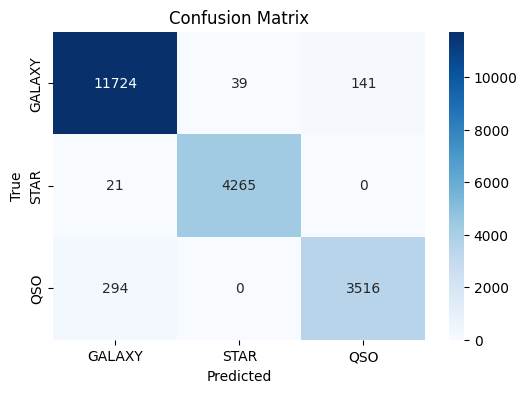

In [26]:
y_pred = xgb_model.predict(X_test)

# Compute precision, recall, f1-score, support (for each class)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_rep)
plot_confusion_matrix(conf_matrix)

In [27]:
print("Best score", xgb_model.best_score)
print("Best iteration", xgb_model.best_iteration)

Best score 0.9957560750411518
Best iteration 88


For every class we get f1 scores above 0.94 which is an improvement compared to the previously trained logistic regression model.
The classes STAR and GALAXY get an almost perfect score with very few false positive and false negative samples. However for the QSO class we obtain a higher number of false negatives and false positives thus affecting the precision and recall scores.

#### Cross validation

This model is fine tuned using a test dataset, which means it is optimized to peform well on this set. For testing how robust the model is, it is better to perform cross validation

In [28]:
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# CV model
xgboost_model = xgboost.XGBClassifier(
    objective="multi:softprob", 
    random_state=42, 
    colsample_bytree=0.98,
    gamma=0.0037, 
    learning_rate=0.097, 
    max_depth=9, 
    n_estimators=147,
    subsample=0.6642,
    eval_metric="auc"
)

cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=5, scoring='roc_auc_ovo_weighted')

In [29]:
cv_scores

array([0.99608309, 0.99567378, 0.9962037 , 0.99584399, 0.99532067])

The f1_macro averages across different folds are very close to each other. This check confirms that the previously trained model is not biased towards the train test split selected.  

#### Model visualization

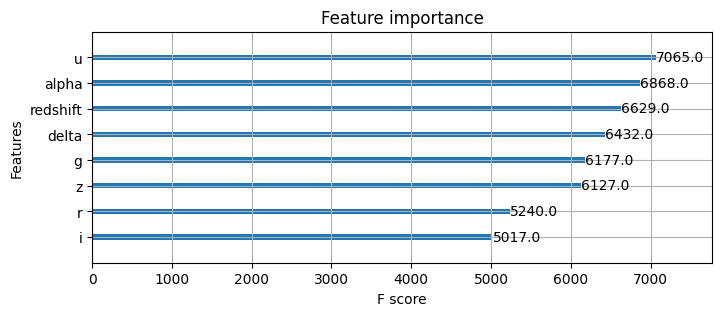

In [30]:
# Set up the matplotlib figure
plt.figure(figsize=(8,3))
ax = plt.gca()

# Flatten the axes array
# axes = axes.flatten()
xgb.plot_importance(xgb_model, height=0.2, ax=ax);
plt.show()
##converts the target tree to a graphviz instance
#xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)

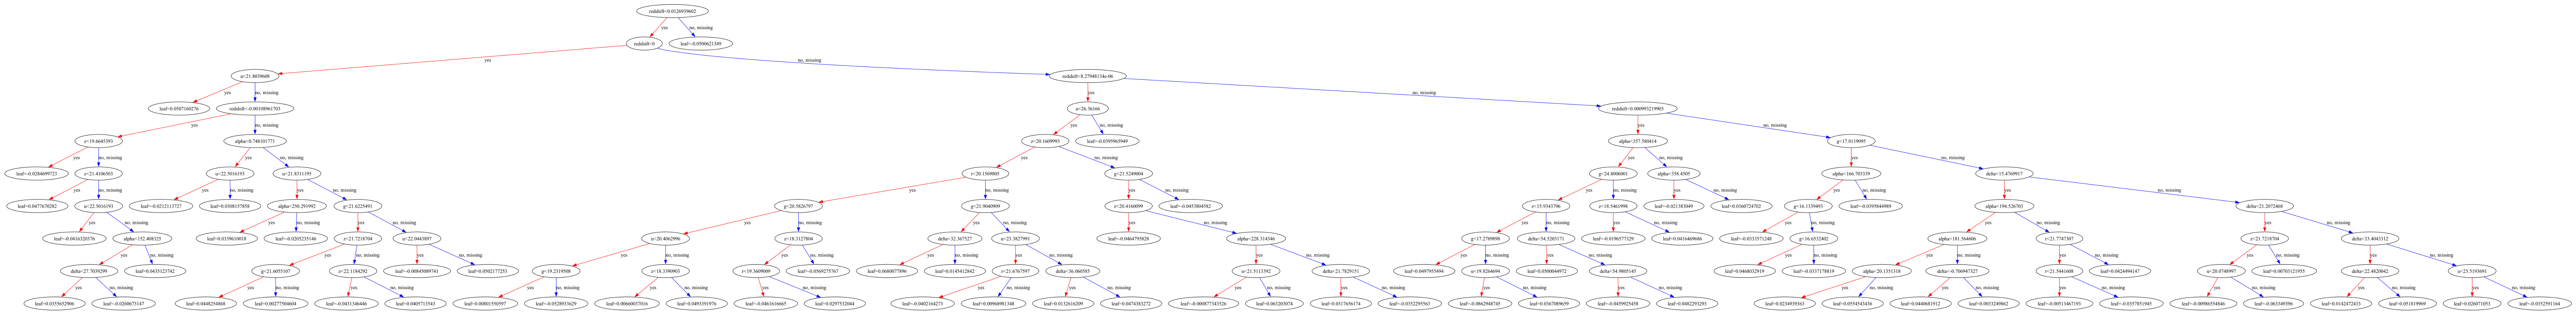

In [31]:
plt.figure(figsize=(100,100))
ax = plt.gca()

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration, ax=ax)
plt.show()

In [32]:
# Save the final model
xgb_model.save_model("models/xgboost_model.json")

In [33]:
xgb_model.predict(X_test.iloc[0:5].values.tolist())

array([2, 1, 1, 1, 0])

#### Test model loading

In [34]:
star_model = xgb.XGBClassifier()
star_model.load_model("models/xgboost_model.json")

In [41]:
X_test.iloc[0:5]

,alpha,delta,u,g,r,i,z,redshift
26002,118.663236,39.642429,22.85773,22.18874,21.35562,21.26577,20.93935,1.174289
80421,358.991830,32.749086,22.62560,22.02104,22.06787,22.44037,22.17338,-0.001960
19864,30.887222,1.188710,18.18911,16.89469,16.42161,16.24627,16.18549,0.000004
81526,118.272263,66.181027,17.57887,16.55078,16.21527,16.10371,16.09738,-0.000165
57878,22.848077,-4.611963,27.10401,22.65568,21.26362,20.04805,19.61308,0.523852


In [37]:
X_test.iloc[0:1].values.tolist()

[[118.663236264366,
  39.6424291996807,
  22.85773,
  22.18874,
  21.35562,
  21.26577,
  20.93935,
  1.174289]]

In [38]:
star_model.predict(X_test.iloc[0:1].values.tolist())

array([2])